In [1]:
#Import the packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import wget
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
#Download the most recent caseshiller dataset from https://fred.stlouisfed.org/
def nationCaseShillerDownload():
    date=str(date.today())
    file_url="https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor=%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_legend=yes&show_axis_titles=yes&drp=0&cosd=1987-01-01&coed={}&height=450&stacking=&range=&mode=fred&id=CSUSHPINSA&transformation=lin&nd=1987-01-01&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml=a&fgst=lin&fgsnd=2009-06-01&fq=Monthly&fam=avg&vintage_date=&revision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=left&mark_type=none&mw=2&width=1168"
    new_url=file_url.format(date)
    file=wget.download(new_url)
nationCaseShillerDownload()

In [ ]:
def nextmonth(date):
    newdate=datetime.strptime(date, '%Y-%m-%d')+relativedelta(months=1)
    newdate=str(newdate.date())
    return newdate

## Simple Moving Average

In [ ]:
#Read and format the csv file into pandas dataframe
file=pd.read_csv("CSUSHPINSA.csv")
df1=pd.DataFrame(file)
df1=df1.rename(columns={"CSUSHPINSA":"Case-Shiller_index"})
df1=df1.append({"DATE":nextmonth(df1[-1:]["DATE"].values[0]),"Case-Shiller_index":None},ignore_index=True)

In [ ]:
#Simple Moving Average Function
def SMA(srs,period):
    new_srs=srs.rolling(period).mean()
    return new_srs

In [ ]:
#Use the SMA function to make forecasting for different time period
df1["SMA_6"]=SMA(df1["Case-Shiller_index"][:-1],6)
df1["SMA_6"]=df1["SMA_6"].shift(1)
df1["SMA_12"]=SMA(df1["Case-Shiller_index"][:-1],12)
df1["SMA_12"]=df1["SMA_12"].shift(1)
df1["SMA_3"]=SMA(df1["Case-Shiller_index"][:-1],3)
df1["SMA_3"]=df1["SMA_3"].shift(1)
df1["DATE"]=pd.to_datetime(df1["DATE"])

In [ ]:
#Calculate the Absolute Error for SMA forecasting models
df1["SMA_3_AbsError"]=abs(df1["SMA_3"]-df1["Case-Shiller_index"])
df1["SMA_6_AbsError"]=abs(df1["SMA_6"]-df1["Case-Shiller_index"])
df1["SMA_12_AbsError"]=abs(df1["SMA_12"]-df1["Case-Shiller_index"])

In [ ]:
df1.to_excel("SMA_Caseshiller.xls")

## Exponential Smoothing
*Single Exponential Smoothing*

*Double Exponential Smoothing*


In [14]:
#Read the file into Pandas Dataframe
file=pd.read_csv("CSUSHPINSA.csv",parse_dates=[0])
df2=pd.DataFrame(file)
df2=df2.rename(columns={"CSUSHPINSA":"Case-Shiller_index"})

In [8]:
#Test Stationality
adtest=adfuller(df2["Case-Shiller_index"])

In [11]:
#Test statistics
adtest[0]

-0.3207215148956879

In [10]:
#Critical Values
dtest[4]

{'1%': -3.4475850438570115,
 '5%': -2.869135963767125,
 '10%': -2.5708164748773332}

In [15]:
#Testing Result
if adtest[0] < adtest[4]["5%"]:
    print ("Reject Ho thus Time Series is Stationary")
else:
    print ("Failed to Reject Ho thus Time Series is Non-Stationary")

Failed to Reject Ho thus Time Series is Non-Stationary


In [18]:
#Read the file
df3=pd.read_csv("CSUSHPINSA.csv",index_col="DATE",parse_dates=True)

In [155]:
#Formatting the date and split into training and testing dataset
df3=df3.asfreq('MS')
df3train=df3[:'2017-12-01']
df3test=df3['2018-01-01':]

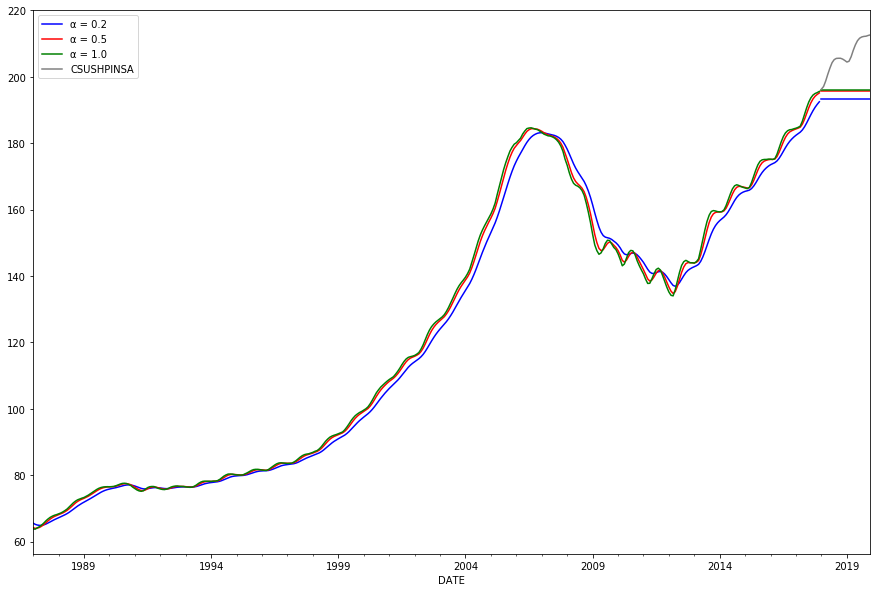

In [156]:
# Simple Exponential Smoothing
fig, ax = plt.subplots(figsize=(15, 10))
fit1 = SimpleExpSmoothing(df3train).fit(smoothing_level=0.2)
fcast1 = fit1.forecast(24).rename("\u03B1 = 0.2")
# plot
fcast1.plot(color='blue', legend=True)
fit1.fittedvalues.plot(color='blue')

fit2 = SimpleExpSmoothing(df3train).fit(smoothing_level=0.5)
fcast2 = fit2.forecast(24).rename("\u03B1 = 0.5")
# plot
fcast2.plot(color='red', legend=True)
fit2.fittedvalues.plot(color='red')


fit3 = SimpleExpSmoothing(df3train).fit()
fcast3 = fit3.forecast(24).rename('\u03B1 = %s'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(color='green', legend=True)
#fit3.fittedvalues.plot(color='green')
ax=fit3.fittedvalues.plot(color='green')
df3test.plot(color="grey",ax=ax)

plt.show()

In [158]:
#Creating Series for each SES model
SES02=fit1.fittedvalues.append(fcast1)
SES06=fit2.fittedvalues.append(fcast2)
SESAuto1=fit3.fittedvalues.append(fcast3)

In [159]:
#Concatenating the series together to form a new dataframe
SES=pd.concat([df3,SES02,SES06,SESAuto1], axis=1)
SES=SES.rename(columns={"CSUSHPINSA":"Case-Shiller_index",0:"Alpha0.2",1:"Alpha0.6",2:"Alpha1"})

In [160]:
#Export into excel file
SES.to_excel("Case_shiller SES.xls")

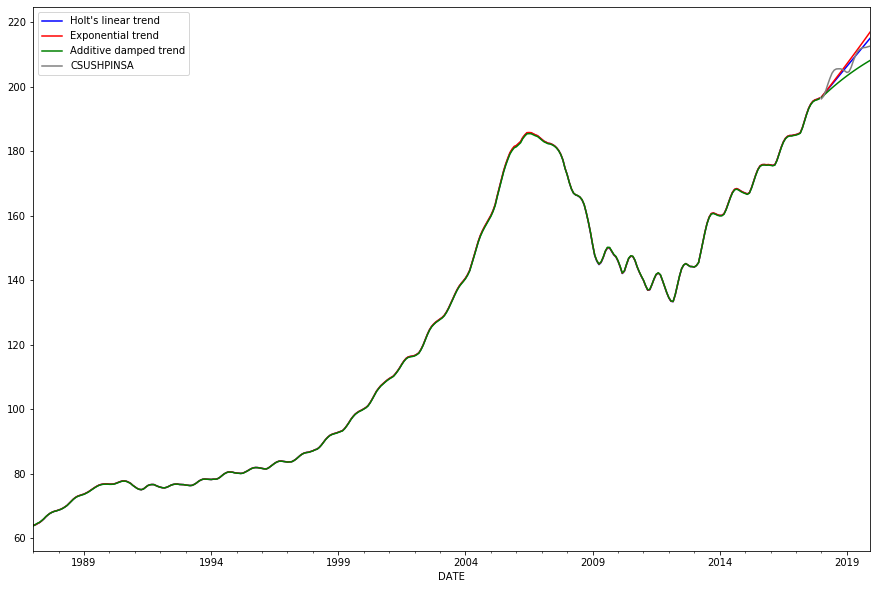

In [161]:
#Double Exponential Moving Average/Considering Trend
fig, ax = plt.subplots(figsize=(15, 10))

#Linear Trend
fit4 = Holt(df3train).fit(smoothing_level=1, smoothing_slope=0.1, optimized=False)
fcast4 = fit4.forecast(24).rename("Holt's linear trend")
fit4.fittedvalues.plot(color='blue')
fcast4.plot(color='blue',legend=True)

#Exponential Trend
fit5 = Holt(df3train, exponential=True).fit(smoothing_level=1, smoothing_slope=0.1, optimized=False)
fcast5 = fit5.forecast(24).rename("Exponential trend")
fit5.fittedvalues.plot(color='red')
fcast5.plot(color='red',legend=True)

#Damped Trend
fit6 = Holt(df3train, damped=True).fit(smoothing_level=1, smoothing_slope=0.1)
fcast6 = fit6.forecast(24).rename("Additive damped trend")
fit6.fittedvalues.plot(color='green')
ax1=fcast6.plot(color='green', legend=True)

df3test.plot(color="grey",ax=ax1)

plt.show()

In [162]:
#Creating Series for each DES model
DESLinear=fit4.fittedvalues.append(fcast4)
DESExponential=fit5.fittedvalues.append(fcast5)
DESdamped=fit6.fittedvalues.append(fcast6)

In [163]:
#Concatenating the series together to form a new dataframe
DES=pd.concat([df3,DESLinear,DESExponential,DESdamped], axis=1)
DES=DES.rename(columns={"CSUSHPINSA":"Case-Shiller_index",0:"LinearTrend",1:"ExponentialTrend",2:"Damped"})

In [164]:
#Export into excel file
DES.to_excel("Case_shiller DES.xls")